## Proyecto 1 - Análisis de Sentimiento de Peliculas
## Parte 1
### Inteligencia de Negocios

#### Grupo 19
Santiago Campo - Pablo Pastrana - Camilo Falla

In [579]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
import numpy as np
import re
import nltk
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\punta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Exploración

In [580]:
# Lectura de los datos
df = pd.read_csv('MovieReviews.csv', encoding = "utf8", sep = ",")

df.drop("Unnamed: 0", inplace=True, axis=1)

df

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,positivo
1,Supongo que algunos directores de películas de...,positivo
2,Es difícil contarle más sobre esta película si...,positivo
3,"La película comienza muy lentamente, con el es...",positivo
4,Esta película es verdadera acción en su máxima...,positivo
...,...,...
4995,"""Criminal decente ordinario"" es triste porque ...",negativo
4996,Savage Island (2003) es una película coja.Es m...,negativo
4997,Quien escribió el script para esta película no...,negativo
4998,in a TV-movie 70's kind of way It's one of tho...,negativo


### 1.1 Clases Balanceadas o Imbalanceadas

In [581]:
df["sentimiento"].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

### 1.2 Largo de las cadenas

In [582]:
df["largo"] = 0

In [583]:
for i in range(len(df["review_es"])):
    df.iloc[i,2] = len(df.iloc[i,0])

In [584]:
df.describe()

,largo
count,5000.000000
mean,1385.930000
std,1032.897373
min,60.000000
25%,750.000000
50%,1030.500000
75%,1699.250000
max,12375.000000


In [585]:
len(df[df["largo"] > 3000])

404

array([[<AxesSubplot:title={'center':'largo'}>]], dtype=object)

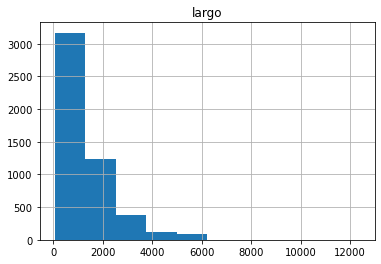

In [586]:
df.hist("largo")

In [587]:
df = df[df.largo < 2500]

In [588]:
df.describe()

,largo
count,4400.000000
mean,1076.017273
std,521.957168
min,60.000000
25%,725.000000
50%,944.500000
75%,1369.000000
max,2498.000000


array([[<AxesSubplot:title={'center':'largo'}>]], dtype=object)

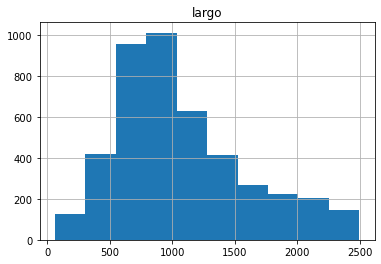

In [589]:
df.hist("largo")

### 1.3 Idioma de las cadenas

In [590]:
df["idioma"] = ""

C:\Users\punta\AppData\Local\Temp/ipykernel_32036/1497573758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["idioma"] = ""


In [592]:
for i in range(len(df["review_es"])):
    df.iloc[i,3] = detect(df.iloc[i,0])

C:\Users\punta\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [593]:
df["idioma"].value_counts(dropna = False)

es    4281
en     118
id       1
Name: idioma, dtype: int64

In [594]:
df = df[df.idioma == "es"]

In [595]:
df["idioma"].value_counts(dropna = False)

es    4281
Name: idioma, dtype: int64

In [596]:
df.describe()

,largo
count,4281.000000
mean,1078.713385
std,521.097891
min,60.000000
25%,727.000000
50%,950.000000
75%,1370.000000
max,2498.000000


## 2. Preprocesamiento

### 2.1 Limpieza y lemmatización

In [597]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for i in range(0, len(df)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(df.iloc[i,0]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

### 2.2 Bag of Words

In [598]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=18000, min_df=5, max_df=0.7, stop_words=stopwords.words('spanish'))
X = vectorizer.fit_transform(documents).toarray()

In [599]:
X.shape

(4281, 9180)

### 2.3 Tfid Transformer

In [600]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [601]:
y = df["sentimiento"]

## 3. Modelo

In [602]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 3.1 SGD Classifier - Camilo Falla

In [603]:
from sklearn.linear_model import SGDClassifier

In [604]:
params = {'loss': ["hinge"],
          'penalty': ["l2"],
          'random_state': [42],
          'max_iter': [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
          'alpha': [0.001],
          'tol': [None]
         }

sgd = GridSearchCV(SGDClassifier(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, random_state=42, max_iter=17, tol=None)
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.001, max_iter=17, random_state=42, tol=None)

In [630]:
y_pred = sgd.predict(X_test)

In [631]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy: ",round(accuracy_score(y_test, y_pred),4))

[[370  54]
 [ 66 367]]
              precision    recall  f1-score   support

    negativo       0.85      0.87      0.86       424
    positivo       0.87      0.85      0.86       433

    accuracy                           0.86       857
   macro avg       0.86      0.86      0.86       857
weighted avg       0.86      0.86      0.86       857

Accuracy:  0.86


### 3.2 Logistic Regression - Pablo Pastrana

In [607]:
from sklearn.linear_model import LogisticRegression

In [608]:
params = {'penalty' : ['l1', 'l2', 'elasticnet'],
    'solver' : ['lbfgs','newton-cg','liblinear'],
    "C": [100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001]
    }
logis = GridSearchCV(LogisticRegression(), param_grid=params, n_jobs=-1, cv=5, verbose=5)

#logis = LogisticRegression(random_state=0)
logis.fit(X_train, y_train) 

Fitting 5 folds for each of 63 candidates, totalling 315 fits


C:\Users\punta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
175 fits failed out of a total of 315.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\punta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\punta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\punta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Val

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear']},
             verbose=5)

In [634]:
y_pred = logis.best_estimator_.predict(X_test)

In [636]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 5))

[[351  73]
 [ 59 374]]
              precision    recall  f1-score   support

    negativo       0.86      0.83      0.84       424
    positivo       0.84      0.86      0.85       433

    accuracy                           0.85       857
   macro avg       0.85      0.85      0.85       857
weighted avg       0.85      0.85      0.85       857

Accuracy:  0.84597


### 3.3 Naive Bayes - Santiago Campo

In [611]:
from sklearn.naive_bayes import MultinomialNB

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* 2, ]
         }

bayes = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
bayes.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
                         'class_prior': [None, [0.1, 0.1]],
                         'fit_prior': [True, False]},
             verbose=5)

In [632]:
y_pred = bayes.best_estimator_.predict(X_test)

In [633]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy: ",round(accuracy_score(y_test, y_pred),4))

[[367  57]
 [ 78 355]]
              precision    recall  f1-score   support

    negativo       0.82      0.87      0.84       424
    positivo       0.86      0.82      0.84       433

    accuracy                           0.84       857
   macro avg       0.84      0.84      0.84       857
weighted avg       0.84      0.84      0.84       857

Accuracy:  0.8425


In [641]:
bayes.best_estimator_.feature_log_prob_

array([[-9.14332768, -9.12968041, -9.62499287, ..., -9.4056442 ,
        -9.56872872, -9.73226155],
       [-9.47008857, -9.20810739, -9.69143861, ..., -9.08431757,
        -9.31150168, -9.64943423]])

### 3.4 Gradient Boosting Classifier - Camilo Falla

In [614]:
from sklearn.ensemble import GradientBoostingClassifier

In [615]:
boost = GradientBoostingClassifier(n_estimators=100, random_state=0)
boost.fit(X_train, y_train) 

GradientBoostingClassifier(random_state=0)

In [616]:
y_pred = boost.predict(X_test)

In [617]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[316 108]
 [ 55 378]]
              precision    recall  f1-score   support

    negativo       0.85      0.75      0.79       424
    positivo       0.78      0.87      0.82       433

    accuracy                           0.81       857
   macro avg       0.81      0.81      0.81       857
weighted avg       0.81      0.81      0.81       857

0.809801633605601


### 3.5 Support Vector Machine - Pablo Pastrana

In [618]:
from sklearn.svm import SVC

In [619]:
svc = SVC(C=1, kernel='linear', degree=3, gamma='auto')
svc.fit(X_train, y_train) 

SVC(C=1, gamma='auto', kernel='linear')

In [620]:
y_pred = svc.predict(X_test)

In [621]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[352  72]
 [ 67 366]]
              precision    recall  f1-score   support

    negativo       0.84      0.83      0.84       424
    positivo       0.84      0.85      0.84       433

    accuracy                           0.84       857
   macro avg       0.84      0.84      0.84       857
weighted avg       0.84      0.84      0.84       857

0.8378063010501751


### 3.6 Random Forest - Santiago Campo

In [622]:
from sklearn.ensemble import RandomForestClassifier

In [623]:
forest = RandomForestClassifier(n_estimators=1000, random_state=0)
forest.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [624]:
y_pred = forest.predict(X_test)

In [625]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[363  61]
 [ 84 349]]
              precision    recall  f1-score   support

    negativo       0.81      0.86      0.83       424
    positivo       0.85      0.81      0.83       433

    accuracy                           0.83       857
   macro avg       0.83      0.83      0.83       857
weighted avg       0.83      0.83      0.83       857

0.8308051341890315
